In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:59, 3391.51it/s]


In [5]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [114]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


### Часть 1. Анализ текстов

1. Посчитайте количество отзывов в разных городах и на разные банки

In [32]:
# pivot = pd.crosstab(df.city, df.bank_name)
# количество отзывов в разных городах
cities = df.groupby(['city']).agg({"num_comments": len}).sort_values("num_comments", ascending=False)
print(cities)

                                  num_comments
city                                          
г. Москва                                55354
г. Санкт-Петербург                       14342
г. Екатеринбург                           2337
г. Новосибирск                            2300
г. Нижний Новгород                        1976
...                                        ...
г. Москва, Ногинск (Москва)                  1
г. Москва, Новосибирск                       1
г. Москва, Николоямская ул., 31              1
г. Москва, Московская область                1
г. … или другой населенный пункт             1

[5823 rows x 1 columns]


In [31]:
# количество отзывов на разные банки
banks = df.groupby(['bank_name']).agg({"num_comments": len}).sort_values("num_comments", ascending=False)
print(banks)

                        num_comments
bank_name                           
Сбербанк России                26327
Альфа-Банк                     10224
ВТБ 24                          8185
Русский Стандарт                7943
Хоум Кредит Банк                7549
...                              ...
Северный Народный Банк             1
Сельмашбанк                        1
Сиббизнесбанк                      1
Сибконтакт                         1
Мигом                              1

[670 rows x 1 columns]


2. Постройте гистограмы длин слов в символах и в словах

3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

In [41]:
from collections import Counter
from nltk.tokenize import word_tokenize
max_records_to_analyze = 1000

In [42]:
# corpus = [token for text in df.text for token in word_tokenize(text)]
corpus = []
for text in df.text[:max_records_to_analyze]:
    for token in word_tokenize(text.lower()):
        corpus.append(token)
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[(',', 16732),
 ('.', 11481),
 ('в', 6183),
 ('и', 5231),
 ('не', 4557),
 ('на', 3491),
 ('что', 3196),
 ('с', 2447),
 ('я', 2368),
 ('по', 2017)]

In [45]:
from string import punctuation
from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')

stops  = stopwords.words('russian') + list(punctuation) + ["``", "''"]

corpus = []
for text in df.text[:max_records_to_analyze]:
    for token in word_tokenize(text.lower()):
        if token in stops:
            continue
        corpus.append(token)
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('банка', 1600),
 ('банк', 1267),
 ('это', 941),
 ('деньги', 629),
 ('карты', 564),
 ('карту', 540),
 ('...', 457),
 ('кредит', 426),
 ('день', 396),
 ('года', 374)]

In [53]:
# с python 3.11 работает версия pymorphy3
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()
corpus = []
for text in df.text[:max_records_to_analyze]:
    for token in word_tokenize(text.lower()):
        if token in stops:
            continue
        morph_form = morph.parse(token)[0]
        lemma = morph_form.normal_form
        corpus.append(lemma)
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('банк', 3841),
 ('карта', 1787),
 ('это', 1018),
 ('мой', 963),
 ('кредит', 926),
 ('который', 865),
 ('деньга', 840),
 ('день', 826),
 ('вклад', 810),
 ('клиент', 730)]

In [60]:
corpus = []
for text in df.text[:max_records_to_analyze]:
    for token in word_tokenize(text.lower()):
        if token in stops:
            continue
        morph_form = morph.parse(token)[0]
        if morph_form.tag.POS!='NOUN':
            continue
        lemma = morph_form.normal_form
        corpus.append(lemma)
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('банк', 3841),
 ('карта', 1787),
 ('кредит', 926),
 ('деньга', 840),
 ('день', 826),
 ('вклад', 810),
 ('клиент', 730),
 ('сотрудник', 720),
 ('счёт', 696),
 ('сумма', 675)]

4. Постройте кривые Ципфа и Хипса

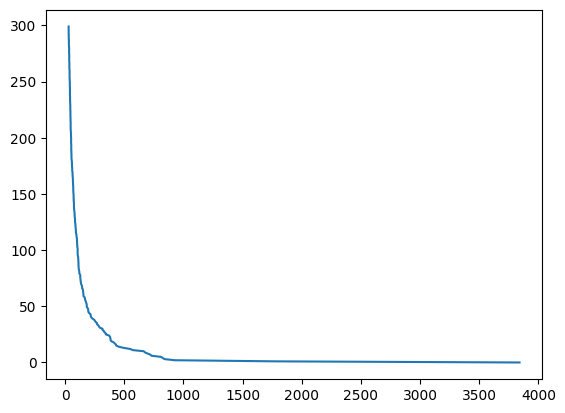

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

TypeError: float() argument must be a string or a real number, not 'dict_values'

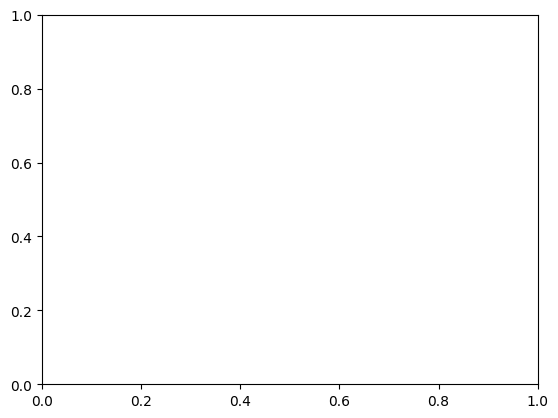

In [75]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []

for text in df.text[:max_records_to_analyze]:
    for token in word_tokenize(text.lower()):
        if token in stops:
            continue
        morph_form = morph.parse(token)[0]
        lemma = morph_form.normal_form
        cnt.update([lemma])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

In [80]:
if cnt["сотрудник"] > cnt["клиент"]:
    print("'сотрудник' встречается чаще")
else:
    print("'клиент' встречается чаще")

'клиент' встречается чаще


In [85]:
lemma_1 = morph.parse("мошенничество")[0].normal_form
lemma_2 = morph.parse("доверие")[0].normal_form
print(f"'мошенничество' встречается {cnt[lemma_1]} раз")
print(f"'доверие' встречается {cnt[lemma_2]} раз")

'мошенничество' встречается 19 раз
'доверие' встречается 32 раз


6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [173]:
high_scores = df[(df.rating_grade==5)]['text']

corpus = []
for text in high_scores[:5000]:
    new_text = []
    for token in word_tokenize(text.lower()):
        if token in stops:
            continue
        lemma = morph.parse(token)[0].normal_form
        new_text.append(lemma)
    corpus.append(" ".join(new_text))


In [174]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
vector = tfidf.fit_transform(corpus)

In [175]:
names = tfidf.get_feature_names_out()
data = vector.todense().tolist()
df_vector= pd.DataFrame(data, columns=names)

In [176]:
cnt_top = Counter(df_vector.idxmax(axis=1))
cnt_top.most_common(10)

[('карта', 79),
 ('вклад', 66),
 ('сделка', 50),
 ('кредит', 45),
 ('ткс', 43),
 ('банк', 25),
 ('банкомат', 21),
 ('курс', 14),
 ('квартира', 14),
 ('депозит', 13)]

In [177]:
low_scores = df[(df.rating_grade==1)]['text']

corpus = []
for text in low_scores[:5000]:
    new_text = []
    for token in word_tokenize(text.lower()):
        if token in stops:
            continue
        lemma = morph.parse(token)[0].normal_form
        new_text.append(lemma)
    corpus.append(" ".join(new_text))

tfidf = TfidfVectorizer(ngram_range=(1, 2))
vector = tfidf.fit_transform(corpus)

names = tfidf.get_feature_names_out()
data = vector.todense().tolist()
df_vector= pd.DataFrame(data, columns=names)

cnt_top = Counter(df_vector.idxmax(axis=1))
cnt_top.most_common(10)

[('карта', 100),
 ('вклад', 64),
 ('страховка', 50),
 ('банкомат', 39),
 ('заявка', 31),
 ('терминал', 30),
 ('кредит', 23),
 ('справка', 22),
 ('страхование', 20),
 ('комиссия', 20)]

### Часть 2. Тематическое моделирование
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

TypeError: 'TfidfVectorizer' object is not subscriptable